In [22]:
import sys

sys.path.append('./divergentmBERT')
import pandas as pd
import numpy as np
import shap
import csv
from string import punctuation
import nltk
from nltk.translate.phrase_based import phrase_extraction
import re
import os
from collections import defaultdict
from IPython.display import display, HTML
import argparse
from divergentscorer import DivergentmBERTScorer
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score
import torch
device = torch.device("cuda" if torch.cuda.is_available() and not True else "cpu")
n_gpu = torch.cuda.device_count()
device = device
refresd_annotations = 'annotations/sd.ali.tsv'
refresd_annotations = 'annotations/sd_inter'

In [23]:
class DivergentmBERT():
    def __init__(self, model, tokenizer, do_lower_case, device):
        self.scorer = DivergentmBERTScorer(model, tokenizer, do_lower_case, device)

    def __call__(self, text_a, text_b):
        return self.scorer.compute_divergentscore(text_a, text_b)

In [24]:
model = DivergentmBERT(model='/fs/clip-divergences/xling-SemDiv/trained_bert/from_WikiMatrix.de-en.tsv.filtered_sample_50000.moses.seed/contrastive_divergence_ranking/rdpg',
                                  tokenizer='bert-base-multilingual-cased',
                                  do_lower_case=False,
                                  device=device)

In [4]:
def ali_to_dict(alis):
    en2fr = defaultdict(list)
    alis = alis.split('), (')
    for ali_ in alis:
        ali_ = re.sub(r'[^\w\s]', '', ali_).split(' ')
        en2fr[ali_[0]].append(ali_[1])
    return en2fr

In [5]:
def ali_to_tuple(alis):
    en2fr = []
    alis = alis.split('), (')
    for ali_ in alis:
        ali_ = re.sub(r'[^\w\s]', '', ali_).split(' ')
        en2fr.append((int(ali_[0]), int(ali_[1])))
    return en2fr

In [6]:
div_to_color = {'3': '#FF7F50',
                '2': '#FFBF00', 
                '1': '#DFFF00',
                '0': '#FFFFFF'}

def color_html(label):
    return f'<span style="background-color:{div_to_color[label]} ">'

def display_HTML(text, div):
    displayed_text = ''
    previous = 'eq'
    mark_end = '</span>'
    for token, label in zip(text.split(' '), div.split(' ')):
        mark = color_html(label)
        if label == '0':
            displayed_text += f' {token}'
            previous = 'eq'
        else:
            if previous == 'div':
                displayed_text += f'{mark} {token}{mark_end}'
            else:
                displayed_text += f' {mark}{token}{mark_end}'
            previous = 'div'
        
    return display(HTML(displayed_text))

In [7]:
def mask_pair(f_text, s_text, f_ind, s_inds):
    f_text = f_text.split(' ')
    s_text = s_text.split(' ')
    f_text[int(f_ind)] = '[MASK]'
    for s_ind in s_inds:
        s_text[int(s_ind)] = '[MASK]'
    return ' '.join(f_text), ' '.join(s_text)

In [8]:
def mask_unaligned(text, masked_ind):
    text = text.split(' ')
    new_text = []
    span = []
    for id_,token in enumerate(text):
        if id_ not in masked_ind:
            new_text.append(token)
        else:
            span.append(token)

    return ' '.join(new_text), span

In [9]:
def unaligned_span(alignment_list, text_len):
    alignment_list = [int(x) for x in alignment_list]
    spans, subspans= [],[]
    unaligned_flag, previous_flag = False, False
    for i in range(text_len):
        #print(f'{i} {subspans}')
        if i not in alignment_list:
            subspans.append(i)
        else:      
            if len(subspans):
                spans.append(subspans)
            subspans = []
    return spans

def flatten(l):
    return [item for sublist in l for item in sublist]

In [10]:
def mask_out_phrase(text, phrase):
    mask = ' [MASK] ' * len(phrase.split(' '))
    mask = '' * len(phrase.split(' '))
    #print(phrase)
    #print(text)
    new_text = f'{text[:text.index(phrase)]}{mask}{text[text.index(phrase)+len(phrase):]}'
    new_text = re.sub(' +', ' ', new_text).rstrip().lstrip()
    #new_text = re.sub(' +', ' ', new_text).rstrip().lstrip().capitalize()
    new_text = ''.join(new_text[:1].upper() + new_text[1:])
    if new_text: 
        if new_text[-1] in punctuation:
            if new_text[-1] == ',':
                new_text[-1] = '.'
            return new_text
        new_text = f'{new_text} .'
    return new_text

def punctuation_spans(text):
    punctuation_flag = True
    for t in text:
        if t not in punctuation and t != ' ':
            punctuation_flag = False
    return punctuation_flag

def phrase_rationale(phrasal_annotations, en_text):
    max_change = -20
    for ann in phrasal_annotations:
        if ann[1][0][0] > max_change and ann[0][2] != en_text:
            max_ann = ann
            max_change = ann[1][0][0]
    return max_ann[0][0], max_ann[0][1], max_ann[1][0][0]

def index_to_div_labels(ind, len_):
    labels = []
    for i in range(len_):
        if i >= ind[0] and i < ind[1]:
            labels.append('1')
        else:
            labels.append('0')
    return ' '.join(labels)

In [20]:
refresd_annotations = 'annotations/ced_en_de_itermax'
def mask_out_phrase(text, phrase):
    mask = ' [MASK] ' * len(phrase.split(' '))
    mask = '' * len(phrase.split(' '))
    #print(phrase)
    #print(text)
    try:
        new_text = f'{text[:text.index(phrase)]}{mask}{text[text.index(phrase)+len(phrase):]}'
        new_text = re.sub(' +', ' ', new_text).rstrip().lstrip().capitalize()
        if new_text: 
            if new_text[-1] in punctuation:
                return new_text
            new_text = f'{new_text} .'
        return new_text
    except ValueError:
        return None
    
def index_to_text(ind, text):
    tokens = []
    for i, token in enumerate(text):
        if i >= ind[0] and i < ind[1]:
            continue
        else:
            tokens.append(token)
    return ' '.join(tokens)

verbose = True
divs_lpo = []
with open(refresd_annotations, 'r') as file_:
    lines = file_.readlines()
    #next(tsv_file)
    verbose = False
    for id_, line in enumerate(lines):
        line = line.split('\t')
        print(f'____________________________________{id_}___________________________________________________')
        if id_ !=233 :
            continue

        en_text = line[0]
        fr_text = line[1]
        en_text_or, fr_text_or = en_text, fr_text
        #en_div = line[2]
        #fr_div = line[3]
        alis = line[2] # (en,fr)
        #print(f'Line {line}')
        #print(alis)
        if not alis:
            print('No alignments!...')
            continue
        en2fr = ali_to_tuple(alis)
  
        
        #display_HTML(en_text, en_div)
        #display_HTML(fr_text, fr_div)
        phrases = phrase_extraction(en_text, fr_text, en2fr)
        
        score = model([f'{en_text}'], [f'{fr_text}'])
        print(f' >> Original Score: {score[0][0]}')
        
        print(f'- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')

        
        global_phrasal_annotations, divergent_flag = [], True  
        count = 0
        while divergent_flag:
            count += 1
            
            phrasal_annotations = []
            
            # Check if deletion of phrases improve over current score
            for phrase in phrases:
                #if phrase in global_phrasal_annotations:
                #    continue

                masked_en = mask_out_phrase(en_text, phrase[2])
                masked_fr = mask_out_phrase(fr_text, phrase[3])
                if not masked_en or not masked_fr:
                    continue
                if punctuation_spans(masked_en) and punctuation_spans(masked_fr):
                    continue

                masked_score = model([masked_en], [masked_fr])
                if masked_score > score:
                    if verbose: 
                        print(f'\n{phrase[2]} ||| {phrase[3]}')
                        #print(f'\n{masked_en} ||| {masked_fr}')
                        #print(f'{en_phrase_len} ||| {fr_phrase_len}')
                        print(score)
                        print(masked_score)
                    phrasal_annotations.append([phrase, masked_score])
                                    
            # If phrasal annotations cannot further improve divergence score exit. 
            print(phrasal_annotations)
            if not phrasal_annotations:
                divergent_flag = False
                continue
            else:
                en_rationale, fr_rationale, masked_score = phrase_rationale(phrasal_annotations, en_text)
                global_phrasal_annotations.append([phrase, masked_score])
                en_text = index_to_text(en_rationale,en_text.split(' '))
                fr_text = index_to_text(fr_rationale,fr_text.split(' '))
                score = masked_score
    
                en_div_lpo = index_to_div_labels(en_rationale,len(en_text_or.split(' ')))
                fr_div_lpo = index_to_div_labels(fr_rationale,len(fr_text_or.split(' ')))
              
            print(f'Revision: {count}')
            display_HTML(en_text_or, en_div_lpo)
            display_HTML(fr_text_or, fr_div_lpo)
            #print(f'{en_text} ||| {fr_text}')

            print(f' >> Masked Score: {masked_score}')
        
        divs_lpo.append([line, en_div_lpo, fr_div_lpo, masked_score])

____________________________________0___________________________________________________
____________________________________1___________________________________________________
____________________________________2___________________________________________________
____________________________________3___________________________________________________
____________________________________4___________________________________________________
____________________________________5___________________________________________________
____________________________________6___________________________________________________
____________________________________7___________________________________________________
____________________________________8___________________________________________________
____________________________________9___________________________________________________
____________________________________10___________________________________________________
____________________

 >> Original Score: 13.711771011352539
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
[[((36, 43), (40, 48), 'against fear , self-centeredness , and exclusivity', 'gegen die Angst , Ichbezogenheit und ausschließende Haltung'), array([[13.842447]], dtype=float32)], [((37, 44), (42, 49), 'fear , self-centeredness , and exclusivity of', 'Angst , Ichbezogenheit und ausschließende Haltung in'), array([[13.841562]], dtype=float32)], [((26, 30), (31, 36), 'to go deeper ,', ', noch tiefer zu gehen'), array([[13.723213]], dtype=float32)], [((26, 34), (31, 40), 'to go deeper , and through our art', ', noch tiefer zu gehen und durch unsere Kunst'), array([[13.820524]], dtype=float32)], [((12, 26), (17, 31), 'great acting " is a call to arms from our fellow craftsmen and women', 'großartige Schauspielkunst " für die Mitglieder der Schauspielervereinigung ein Ruf zu den Waffen ist'), array([[13.850991]], dtype=float32)], [((11, 31), (16, 37), 'that grea

 >> Masked Score: 13.859939575195312
[[((36, 39), (40, 44), 'against fear ,', 'gegen die Angst ,'), array([[13.862534]], dtype=float32)], [((2, 3), (3, 5), ',', 'im Rahmen'), array([[13.862464]], dtype=float32)], [((8, 9), (14, 15), 'award', 'Award'), array([[13.864085]], dtype=float32)], [((2, 9), (3, 15), ', accepting a Screen Actors Guild award', 'im Rahmen seiner Dankesrede nach der Verleihung des Screen Actors Guild Award'), array([[13.86331]], dtype=float32)], [((5, 7), (11, 13), 'Screen Actors', 'Screen Actors'), array([[13.860765]], dtype=float32)], [((42, 45), (46, 50), 'exclusivity of our', 'ausschließende Haltung in unserer'), array([[13.863573]], dtype=float32)], [((4, 8), (10, 14), 'a Screen Actors Guild', 'des Screen Actors Guild'), array([[13.861962]], dtype=float32)], [((38, 43), (43, 48), ', self-centeredness , and exclusivity', ', Ichbezogenheit und ausschließende Haltung'), array([[13.863266]], dtype=float32)], [((6, 7), (12, 13), 'Actors', 'Actors'), array([[13.8629

 >> Masked Score: 13.866158485412598
[[((36, 39), (40, 44), 'against fear ,', 'gegen die Angst ,'), array([[13.866284]], dtype=float32)], [((42, 45), (46, 50), 'exclusivity of our', 'ausschließende Haltung in unserer'), array([[13.866362]], dtype=float32)], [((40, 43), (45, 48), ', and exclusivity', 'und ausschließende Haltung'), array([[13.866935]], dtype=float32)], [((42, 43), (46, 48), 'exclusivity', 'ausschließende Haltung'), array([[13.866826]], dtype=float32)], [((36, 37), (40, 42), 'against', 'gegen die'), array([[13.867204]], dtype=float32)], [((42, 46), (46, 51), 'exclusivity of our predominantly', 'ausschließende Haltung in unserer überwiegend'), array([[13.8665285]], dtype=float32)], [((42, 44), (46, 49), 'exclusivity of', 'ausschließende Haltung in'), array([[13.866714]], dtype=float32)], [((30, 31), (36, 37), 'and', 'und'), array([[13.8663645]], dtype=float32)], [((36, 37), (40, 41), 'against', 'gegen'), array([[13.866713]], dtype=float32)], [((45, 46), (50, 51), 'predomin

 >> Masked Score: 13.867203712463379
[]
____________________________________234___________________________________________________
____________________________________235___________________________________________________
____________________________________236___________________________________________________
____________________________________237___________________________________________________
____________________________________238___________________________________________________
____________________________________239___________________________________________________
____________________________________240___________________________________________________
____________________________________241___________________________________________________
____________________________________242___________________________________________________
____________________________________243___________________________________________________
____________________________________244___________

In [18]:
phrases

{((0, 1), (0, 1), 'Elected', 'Gewählte'),
 ((0, 2), (0, 2), 'Elected officials', 'Gewählte Vertreter'),
 ((0, 10),
  (0, 11),
  'Elected officials everywhere must adjust , to varying degrees ,',
  'Gewählte Vertreter müssen sich - in unterschiedlichem Ausmaß - überall anpassen'),
 ((0, 11),
  (0, 12),
  'Elected officials everywhere must adjust , to varying degrees , to',
  'Gewählte Vertreter müssen sich - in unterschiedlichem Ausmaß - überall anpassen ,'),
 ((0, 11),
  (0, 13),
  'Elected officials everywhere must adjust , to varying degrees , to',
  'Gewählte Vertreter müssen sich - in unterschiedlichem Ausmaß - überall anpassen , um'),
 ((0, 19),
  (0, 18),
  'Elected officials everywhere must adjust , to varying degrees , to fulfill the expectations of those who put them',
  'Gewählte Vertreter müssen sich - in unterschiedlichem Ausmaß - überall anpassen , um die Erwartungen jener zu erfüllen'),
 ((0, 20),
  (0, 18),
  'Elected officials everywhere must adjust , to varying degrees

In [78]:
# NEWWWWW
import string
def mask_out_phrase(text, phrase):
    #mask = ' [MASK] ' * len(phrase.split(' '))
    mask = '' * len(phrase.split(' '))
    #print(phrase)
    #print(text)
    try:
        new_text = f'{text[:text.index(phrase)]}{mask}{text[text.index(phrase)+len(phrase):]}'
        new_text = re.sub(' +', ' ', new_text).rstrip().lstrip().capitalize()
        if new_text: 
            if new_text[-1] in punctuation:
                return new_text
            new_text = f'{new_text} .'
        return new_text
    except ValueError:
        return None
    
def index_to_text(ind, text):
    tokens = []
    for i, token in enumerate(text):
        if i >= ind[0] and i < ind[1]:
            continue
        else:
            tokens.append(token)
    return ' '.join(tokens)


def phrase_rationale(phrasal_annotations, en_text):
    max_change = -20
    print(phrasal_annotations)
    sorted_annotations = defaultdict()
    for ann in phrasal_annotations:
        if ann[1][0][0] > max_change and ann[0][2] != en_text:
            max_ann = ann
            max_change = ann[1][0][0]
    return max_ann[0][0], max_ann[0][1], max_ann[1][0][0]


def strip_punctuation(text):
    stripped_text = text.translate(str.maketrans('', '', string.punctuation)).split(' ')
    tokens = []
    for token in stripped_text:
        if token != '':
            tokens.append(token)
    return  ' '.join(tokens)

verbose = True
strip_punctuation_flag = True
divs_lpo = []
with open(refresd_annotations, 'r') as file_:
    lines = file_.readlines()
    #next(tsv_file)
    verbose = True
    for id_, line in enumerate(lines):
        line = line.split('\t')
        print(f'____________________________________{id_}___________________________________________________')
        if id_ != 1:
            continue

        en_text = line[0]
        fr_text = line[1]
        en_text_or, fr_text_or = en_text, fr_text
        en_div = line[2]
        fr_div = line[3]
        alis = line[4] # (en,fr)
        #print(f'Line {line}')
        #print(alis)
        if not alis:
            print('No alignments!...')
            continue
        en2fr = ali_to_tuple(alis)
  
        
        display_HTML(en_text, en_div)
        display_HTML(fr_text, fr_div)
        phrases = phrase_extraction(en_text, fr_text, en2fr)
        
        if strip_punctuation_flag: 
            score = model([f'{strip_punctuation(en_text)}'], [f'{strip_punctuation(fr_text)}'])
        else:
            score = model([f'{en_text}'], [f'{fr_text}'])
            
        print(f' >> Original Score: {score[0][0]}')
        
        print(f'- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')

        
        global_phrasal_annotations, divergent_flag = [], True  
        count = 0
        while divergent_flag and count == 0:
            count += 1
            
            phrasal_annotations = []
            
            # Check if deletion of phrases improve over current score
            for phrase in phrases:
                #if phrase in global_phrasal_annotations:
                #    continue

                masked_en = mask_out_phrase(en_text, phrase[2])
                masked_fr = mask_out_phrase(fr_text, phrase[3])
                if not masked_en or not masked_fr:
                    continue
                if punctuation_spans(masked_en) and punctuation_spans(masked_fr):
                    continue

                if strip_punctuation_flag:
                    masked_score = model([strip_punctuation(masked_en)], [strip_punctuation(masked_fr)])
                else:
                    masked_score = model([masked_en], [masked_fr])
                if masked_score > score:
                    if verbose: 
                        print(f'\n{phrase[2]} ||| {phrase[3]}')
                        #print(f'\n{masked_en} ||| {masked_fr}')
                        #print(f'{en_phrase_len} ||| {fr_phrase_len}')
                        print(strip_punctuation(masked_en))
                        print(strip_punctuation(masked_fr))
                        print(score)
                        print(masked_score)
                    phrasal_annotations.append([phrase, masked_score])
                                    
            # If phrasal annotations cannot further improve divergence score exit. 
            if not phrasal_annotations:
                divergent_flag = False
                continue
            else:
                en_rationale, fr_rationale, masked_score = phrase_rationale(phrasal_annotations, en_text)
                global_phrasal_annotations.append([phrase, masked_score])
                en_text = index_to_text(en_rationale,en_text.split(' '))
                fr_text = index_to_text(fr_rationale,fr_text.split(' '))
                score = masked_score
    
                en_div_lpo = index_to_div_labels(en_rationale,len(en_text_or.split(' ')))
                fr_div_lpo = index_to_div_labels(fr_rationale,len(fr_text_or.split(' ')))
              
            print(f'Revision: {count}')
            display_HTML(en_text_or, en_div_lpo)
            display_HTML(fr_text_or, fr_div_lpo)
            #print(f'{en_text} ||| {fr_text}')

            print(f' >> Masked Score: {masked_score}')
        
        divs_lpo.append([line, en_div_lpo, fr_div_lpo, masked_score])

____________________________________0___________________________________________________
____________________________________1___________________________________________________


 >> Original Score: -15.307981491088867
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

) ; Cothirtiacus ( ||| ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium seruiuit quattuor domibus
[[-15.3079815]]
[[-15.172853]]

of war ) ; Patricius ( that is , father of the citizens ||| belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god cothirtiacus because he served four houses of druids
Tír


; Succetus ( that is , the god of war ) ; Patricius ( that is , ||| ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.229664]]

the book of ||| le Livre de
Tírechán writes i found four names for patrick written in ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est


, the god of war ) ; Patricius ( ||| deus belli ) , Patricius (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.990726]]

written in the book of Ultán , bishop of the ||| , dit-il , dans le Livre de l' évêque Ultan
Tírechán writes i found four names for patrick tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés sanctus magonus qui est clarus succetus qui est deus belli patricius qui est p


, the god of war ) ; Patricius ( that is , father of ||| deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.1992035]]

the god of war ) ; Patricius ( that is , father of the citizens ) ||| deus belli ) , Patricius ( qui est pater ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est


of the citizens ) ; Cothirtiacus ( because ||| pater ciuium ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.240587]]

the god of war ) ; Patricius ( that is , father of ||| deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus s


Magonus ( that is ||| Sanctus Magonus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.048689]]

, " famous " ) ||| clarus )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est succetus qui est deus belli patricius qui est pater ciu


, the god of war ) ; Patricius ( that is , father of the ||| deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.080662]]

father of the citizens ) ; Cothirtiacus ( ||| ciuium ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deu


" ) ; Succetus ( that is , the god of war ) ; Patricius ( that is ||| ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.229664]]

" ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de 


four names ||| les quatre noms
Tírechán writes i found for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.12157]]

Cothirtiacus ( because ||| Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est p


) ; Succetus ( that is , the god of war ) ; Patricius ( that is , ||| ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.126436]]

( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ||| ( qui est deus belli ) , Patricius ( qui est pater ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ulta


tribe of Conchobar : holy ||| :
Tírechán writes i found four names for patrick written in the book of ultán bishop of the magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.292257]]

is , the god ||| est deus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui belli patricius qui est pater ciuium coth


is , " famous " ) ; Succetus ( that is , the god of war ) ||| est clarus ) ; Succetus ( qui est deus belli )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.070293]]

war ) ; Patricius ( that is , ||| belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetu


found ||| a trouvés , dit-il
Tírechán writes i four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.181278]]

Patrick written ||| Patrick
Tírechán writes i found four names for in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirt


, father of the citizens ) ; ||| ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.102826]]

) ; Patricius ( that is ||| ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est


because he ||| il a
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus served four houses of druids
Tírechán rapporte les quatre noms de patrick qu trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.9893265]]

that is , the god of war ) ; Patricius ( that is , father of the citizens ) ||| qui est deus belli ) , Patricius ( qui est pater ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est claru


" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ; Cothirtiacus ( ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.234598]]

father of the citizens ) ; Cothirtiacus ||| pater ciuium ) ; Cothirthiacus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui e


is ||| est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bhop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.592539]]

is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus mago


the citizens ) ; Cothirtiacus ( because ||| ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.23119]]

is , " famous " ) ; Succetus ( that is , ||| clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est deus belli patricius 


famous " ) ; Succetus ( that is , the god of war ||| clarus ) ; Succetus ( qui est deus belli
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.074055]]

, " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan san


Succetus ( that is , the god of ||| Succetus ( qui est deus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.986204]]

" ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of ||| ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qu


Magonus ( that is , " ||| Magonus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.074512]]

" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is ||| est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanct


, the god of war ) ; Patricius ( that is , father of the citizens ||| deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.173231]]

; Succetus ( that is , the god of war ) ; Patricius ( that is ||| ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonu


holy Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ||| Magonus ( qui est clarus ) ; Succetus ( qui est deus belli ) , Patricius
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.302499]]

writes ||| rapporte
Tírechán i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius


the god of war ) ; Patricius ( that is , ||| deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.124271]]

in the book of Ultán , bishop of the tribe of Conchobar : ||| , dit-il , dans le Livre de l' évêque Ultan :
Tírechán writes i found four names for patrick written holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés sanctus magonus qui est clarus succetus qui est deus belli patricius qui e


book of ||| Livre de
Tírechán writes i found four names for patrick written in the ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.082568]]

four names for Patrick ||| quatre noms de Patrick qu'
Tírechán writes i found written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthi


famous " ) ; Succetus ( ||| clarus ) ; Succetus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.937494]]

) ; Succetus ( that is , the god of ||| ; Succetus ( qui est deus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus belli patricius qui e


" ) ; Succetus ( that is , the god of war ) ; Patricius ( ||| ) ; Succetus ( qui est deus belli ) , Patricius (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.224975]]

god of war ) ; ||| deus belli )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est patrici


holy Magonus ( that is ||| Sanctus Magonus ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.09107]]

" famous " ) ; Succetus ( that is , the ||| clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est deus belli patricius qui est pa


( that is , ||| ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.12266]]

god of war ) ; Patricius ( that is , ||| deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est pate


holy Magonus ( that ||| Sanctus Magonus ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.254192]]

famous " ) ; ||| est clarus ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui succetus qui est deus belli patricius qui est pater ciu


that is , " famous " ) ; Succetus ( that is , ||| qui est clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.016785]]

war ) ; Patricius ( that is , father of the ||| belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qu


" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.004423]]

; Patricius ( that is , father of ||| , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succe


that is , the god of war ) ; Patricius ( that is , ||| qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.129978]]

, the god of war ) ; Patricius ||| deus belli ) , Patricius
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est qui e


; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ||| ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.299551]]

) ; Cothirtiacus ( because ||| pater ciuium ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus s


god of war ) ; Patricius ( that is , father of the citizens ||| deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.204067]]

war ||| belli
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus patricius qui est pater ciu


, father of the citizens ) ||| ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.104606]]

that is , father of the ||| qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus clarus succetus qui est deus belli patricius qui est pater ciuium co


war ) ; Patricius ( that is , ||| belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.041979]]

holy Magonus ( that is , " famous " ) ||| Sanctus Magonus ( qui est clarus )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan succetus qui est deus belli patricius qui


Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war ) ; ||| Magonus ( qui est clarus ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.089687]]

god of war ) ||| deus belli )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est patri


that is , father of the citizens ) ||| qui est pater ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.000809]]

is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan s


bishop of the tribe ||| l' évêque
Tírechán writes i found four names for patrick written in the book of ultán of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.249983]]

Succetus ( that is , the god of war ) ; Patricius ( that is , ||| Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui 


" famous ||| est clarus )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.245083]]

holy Magonus ( that is , " famous " ) ||| Sanctus Magonus ( qui est clarus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan succetus qui est deus belli patricius qui est pater c


that is , ||| qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.12266]]

, father of the citizens ) ; Cothirtiacus ( because ||| ciuium ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli 


the god of war ) ; Patricius ( that is , father ||| deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.213425]]

god of war ) ; Patricius ( that is , ||| deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succet


famous " ) ; Succetus ( that is ||| est clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.015413]]

Patricius ( that is , father of the citizens ) ; Cothirtiacus ||| Patricius ( qui est pater ciuium ) ; Cothirthiacus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est cla


of the citizens ) ; Cothirtiacus ( because ||| ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.173863]]

Magonus ( that is , " famous ||| Magonus ( qui est clarus )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus succetus qui est deus belli patricius qui est p


that is , " famous " ||| qui est clarus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.931755]]

god of war ) ; Patricius ||| deus belli ) , Patricius
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est qui est pater ciu


of the citizens ) ; ||| ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.008699]]

of war ) ; Patricius ( that is , father ||| belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus p


Succetus ( that is , the god of war ) ; Patricius ( that is ||| Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.126436]]

that is , " famous ||| qui est clarus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus succetus qui est deus belli patricius qui est p


in ||| dans
Tírechán writes i found four names for patrick written the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.908981]]

is , " famous " ) ; Succetus ( that is , ||| est clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui deus belli patricius qui est pat


" ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the ||| ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.248405]]

, father of the citizens ) ; Cothirtiacus ( because ||| ciuium ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succet


" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.208456]]

, " famous " ) ; Succetus ( that is , the god of war ) ; ||| est clarus ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan s


; Succetus ( that is , the god of war ||| ) ; Succetus ( qui est deus belli
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.083412]]

" ) ; Succetus ( that is , the god of war ) ||| ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus patrici


famous " ) ; Succetus ( that is , the god of war ) ; Patricius ||| est clarus ) ; Succetus ( qui est deus belli ) , Patricius
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.145893]]

( that is , the god of war ) ; Patricius ( that is , father of the ||| ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui


; Succetus ( that is , the god of war ) ; Patricius ( that is , ||| ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.210575]]

war ) ; Patricius ( that is , father of the citizens ) ||| belli ) , Patricius ( qui est pater ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui e


( that is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , ||| ( qui est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.252741]]

is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ; Cothirtiacus ( because ||| est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that he served four houses of druids
Tírechán rapporte les quatre no


written in the book of Ultán , bishop of the tribe of Conchobar : ||| , dit-il , dans le Livre de l' évêque Ultan :
Tírechán writes i found four names for patrick holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.211782]]

Patricius ( that ||| Patricius ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli est pater c


" famous " ) ; Succetus ( that is , ||| est clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.015413]]

, " famous " ) ; Succetus ||| est clarus ) ; Succetus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui qui est deus belli patricius


Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ; ||| Magonus ( qui est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.293437]]

written in the book of Ultán , bishop of the tribe of Conchobar : holy ||| , dans le Livre de l' évêque Ultan :
Tírechán writes i found four names for patrick magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil sanctus magonus qui est clarus succetus qui e


" famous " ) ; Succetus ( that is , the god of war ) ||| est clarus ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.075092]]

holy Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war ||| Sanctus Magonus ( qui est clarus ) ; Succetus ( qui est deus belli
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque


holy Magonus ( that is , " famous " ) ; Succetus ( that ||| Magonus ( qui est clarus ) ; Succetus ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.279595]]

god of war ) ; Patricius ( that is , father ||| deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est claru


Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war ) ||| Sanctus Magonus ( qui est clarus ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.119608]]

; Succetus ( that ||| ; Succetus ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus est deus belli pat


famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.289576]]

) ; Patricius ( that is , father ||| ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus s


Succetus ( that is , the god of war ) ; Patricius ( that is , father of ||| Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.251398]]

, the god of war ) ; Patricius ( that is , father of the citizens ||| deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est claru


" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.294376]]

for ||| de
Tírechán writes i found four names patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius


; Succetus ( that is , the god of war ) ||| ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.083412]]

Patricius ( that is , father of the citizens ) ; ||| , Patricius ( qui est pater ciuium ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succ


( that is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , ||| ( qui est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.199959]]

; Cothirtiacus ||| ; Cothirthiacus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui 


Patricius ||| Patricius
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.903237]]

the citizens ) ; ||| ciuium ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater co


; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the ||| ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.1527195]]

" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de


( that is , the god of war ) ; Patricius ( that is ||| ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.157595]]

god of war ) ; Patricius ( that is , father of the ||| deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus


the god ||| deus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.896532]]

, the god of war ) ; Patricius ( that is , ||| deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est pater c


citizens ) ; Cothirtiacus ( because ||| pater ciuium ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.184389]]

" famous " ) ; Succetus ( that is ||| est clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui deus belli patricius qui


holy Magonus ( ||| Sanctus Magonus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan qui est clarus succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.96891]]

, " I found four names for Patrick written in the book of Ultán , bishop of the tribe of Conchobar : holy Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ; Cothirtiacus ( because he served four ||| les quatre noms de Patrick qu' il a trouvés , dit-il , dans le Livre de l' évêque Ultan : " Sanctus Magonus ( qui est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ci


father of the citizens ) ; Cothirtiacus ( ||| pater ciuium ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est seruiuit quattuor domibus
[[-15.3079815]]
[[-15.217049]]

) ; Succetus ( that is , the god of war ) ||| ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus patricius


" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ; Cothirtiacus ( ||| est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium ) ; Cothirthiacus (
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.2698555]]

that is , father of the citizens ) ; Cothirtiacus ||| qui est pater ciuium ) ; Cothirthiacus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus ma


; Succetus ( that is , the god of war ||| ; Succetus ( qui est deus belli
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.083412]]

holy Magonus ( that is , " famous ||| Magonus ( qui est clarus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus succetus qui est deus belli patricius qui est pater


) ; Patricius ( that is , ||| ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.953079]]

; Patricius ( that is , father of the citizens ) ||| , Patricius ( qui est pater ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus q


, " famous " ) ; Succetus ( that is , the god ||| est clarus ) ; Succetus ( qui est deus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.978445]]

I found ||| a trouvés , dit-il
Tírechán writes four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est 


of the citizens ) ; Cothirtiacus ( because ||| ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium seruiuit quattuor domibus
[[-15.3079815]]
[[-15.172939]]

( that is , the god of war ) ; Patricius ( that is , ||| ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qu


the citizens ) ; Cothirtiacus ( because ||| ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est pater ciuium seruiuit quattuor domibus
[[-15.3079815]]
[[-15.248543]]

that is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is ||| qui est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque u


citizens ) ; Cothirtiacus ( because ||| pater ciuium ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui est seruiuit quattuor domibus
[[-15.3079815]]
[[-15.174221]]

is , the god of war ||| est deus belli
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui patricius qui est pater ciu


; Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.26181]]

that is , the god of war ) ; Patricius ( that ||| qui est deus belli ) , Patricius ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus


that is , the god of war ) ; Patricius ( that is , ||| qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.157595]]

, " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêq


, " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ; Cothirtiacus ( ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est seruiuit quattuor domibus
[[-15.3079815]]
[[-15.304142]]

famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , ||| clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés dit


Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ||| Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.299551]]

father of the citizens ) ; ||| ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patricius qui


Succetus ( that is , the god of war ) ; Patricius ( that is , father ||| Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.26181]]

; Patricius ( that is ||| , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus be


" ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the ||| ; Succetus ( qui est deus belli ) , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.1527195]]

Patricius ( that is , father ||| Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus q


, " famous " ||| est clarus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.245083]]

) ; Cothirtiacus ( because ||| ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is father of the citizens he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patr


, the god of war ) ; Patricius ( that is , father of the citizens ) ; ||| deus belli ) , Patricius ( qui est pater ciuium ) ;
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.21666]]

father of the citizens ) ; Cothirtiacus ( because ||| ) ; Cothirthiacus ( quia
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius that is he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui es


is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is ||| est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.25935]]

Magonus ( that is , " ||| Magonus ( qui
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy famous succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus est clarus succetus qui est deus belli pa


" famous ||| est clarus
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is succetus that is the god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui succetus qui est deus belli patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.245083]]

( that is , father of the citizens ) ||| ( qui est pater ciuium )
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war patricius cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli patriciu


; Patricius ( that is , father of the ||| , Patricius ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of war citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus qui est deus belli pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-14.911516]]

war ) ; Patricius ( that is , father ||| belli ) , Patricius ( qui est pater ciuium
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that is famous succetus that is the god of of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est clarus succetus


is , " famous " ) ; Succetus ( that is , the god of war ) ; ||| clarus ) ; Succetus ( qui est deus belli ) ,
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus that patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus qui est patricius qui est pater ciuium cothirthiacus quia seruiuit quattuor domibus
[[-15.3079815]]
[[-15.077198]]

( that is , " famous " ) ; Succetus ( that is , the ||| ( qui est clarus ) ; Succetus ( qui est
Tírechán writes i found four names for patrick written in the book of ultán bishop of the tribe of conchobar holy magonus god of war patricius that is father of the citizens cothirtiacus because he served four houses of druids
Tírechán rapporte les quatre noms de patrick qu il a trouvés ditil dans le livre de l évêque ultan sanctus magonus 

 >> Masked Score: 12.219352722167969
____________________________________2___________________________________________________
____________________________________3___________________________________________________
____________________________________4___________________________________________________
____________________________________5___________________________________________________
____________________________________6___________________________________________________
____________________________________7___________________________________________________
____________________________________8___________________________________________________
____________________________________9___________________________________________________
____________________________________10___________________________________________________
____________________________________11___________________________________________________
____________________________________12_________________________________

In [75]:
def mask_out_phrase(text, phrase):
    mask = ' [MASK] ' * len(phrase.split(' '))
    mask = '' * len(phrase.split(' '))
    #print(phrase)
    #print(text)
    try:
        new_text = f'{text[:text.index(phrase)]}{mask}{text[text.index(phrase)+len(phrase):]}'
        new_text = re.sub(' +', ' ', new_text).rstrip().lstrip().capitalize()
        if new_text: 
            if new_text[-1] in punctuation:
                return new_text
            new_text = f'{new_text} .'
        return new_text
    except ValueError:
        return None
    
def index_to_text(ind, text):
    if not ind:
        return ' '.join(text)
    tokens = []
    for i, token in enumerate(text):
        if i >= ind[0] and i < ind[1]:
            continue
        else:
            tokens.append(token)
    return ' '.join(tokens)

def index_to_div_labels(ind, len_):
    if not ind:
        return ' '.join(['0']*len_)
    labels = []
    for i in range(len_):
        if i >= ind[0] and i < ind[1]:
            labels.append('1')
        else:
            labels.append('0')
    return ' '.join(labels)

def get_unaligned_phrases(aligned_indices, text):
    unaligned_phrase, unaligned_ind,  unaligned_phrases = [], [], []
    for i in range(len(text.split(' '))):
        if i not in aligned_indices:
            unaligned_phrase.append(text.split(' ')[i])
            unaligned_ind.append(i)
        else:
            if unaligned_phrase and len(unaligned_phrase) > 1:
                #print(f'({unaligned_ind[0]}, {unaligned_ind[-1]})')
                unaligned_phrases.append([(unaligned_ind[0], unaligned_ind[-1] +1), ' '.join(unaligned_phrase)])
            unaligned_phrase = [] 
            unaligned_ind = []
    return unaligned_phrases


def minimal_phrase_rationale(phrasal_annotations, en_text, fr_text):
    
    max_change = -1000000
    for ann in phrasal_annotations:
  
        #d_phrase = min(len(ann[0][2].split(' ')) , len(ann[0][3].split(' '))) 
        d_phrase = len(ann[0][2].split(' ')) + len(ann[0][3].split(' '))
        d_sent = len(en_text.split(' ')) + len(fr_text.split(' '))
        # exponential
        #weighted_score = float(ann[1])* np.sqrt(np.exp(-(d ** 2) / 10 ** 2))
        weighted_score = float(ann[1])* (d_sent/d_phrase)
        
        #print(f'\nOrigi: {ann[1][0][0]}')
        #print(f'Wig: {weighted_score}')
        #print(ann[0][2])
        #print(ann[0][3])
        #print(d)
        if weighted_score > max_change:# and ann[0][2] != en_text:
            max_ann = ann
            max_change = weighted_score
    return max_ann[0][0], max_ann[0][1], max_ann[1]

def constrained_phrase_rationale(phrasal_annotations, en_text, fr_text):
    
    min_phrase = 100
    for ann in phrasal_annotations:
  
        #d_phrase = len(ann[0][2].split(' ')) + len(ann[0][3].split(' '))
        d_phrase = min(len(ann[0][2].split(' ')) , len(ann[0][3].split(' ')))
        d_sent = len(en_text.split(' ')) + len(fr_text.split(' '))        
        
        if d_phrase < min_phrase:# and ann[0][2] != en_text:
            min_ann = ann
            min_phrase = d_phrase
    return min_ann[0][0], min_ann[0][1], min_ann[1]

verbose = True
paired_phrases, missing_phrases = True, True
divs_lpo = []
with open(refresd_annotations, 'r') as file_:
    lines = file_.readlines()
    for id_, line in enumerate(lines):
        line = line.split('\t')
        print(f'____________________________________{id_}___________________________________________________')
        if id_ != 0:
            continue

        en_text = line[0]
        fr_text = line[1]
        en_text_or, fr_text_or = en_text, fr_text
        en_div = line[2]
        fr_div = line[3]
        alis = line[4] # (en,fr)
        #print(f'Line {line}')
        #print(alis)
        if not alis:
            print('No alignments!...')
            continue
        en2fr = ali_to_tuple(alis)
  
        
        display_HTML(en_text, en_div)
        display_HTML(fr_text, fr_div)
        
        phrases = set()
        if paired_phrases:
            phrases = phrase_extraction(en_text, fr_text, en2fr)
            #print(phrases)
        
        if missing_phrases:
            en_aligned, fr_aligned = [], []
            for (en_a, fr_a) in en2fr:
                en_aligned.append(en_a)
                fr_aligned.append(fr_a)
            en_unaligned = get_unaligned_phrases(en_aligned, en_text)
            fr_unaligned = get_unaligned_phrases(fr_aligned, fr_text)
            for phrase in en_unaligned:
                phrases.add((phrase[0], None, phrase[1], ''))
            for phrase in fr_unaligned:
                phrases.add((None, phrase[0], '', phrase[1]))
            
        
        score = model([f'{en_text}'], [f'{fr_text}'])
        print(f' >> Original Score: {score[0][0]}')
        
        print(f'- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
        
        global_phrasal_annotations, divergent_flag = [], True  
        count = 0
        while divergent_flag:
            count += 1
            
            phrasal_annotations = []
            
            # Check if deletion of phrases improve over current score
            for phrase in phrases:
                
                #if phrase in global_phrasal_annotations:
                #    continue

                masked_en = mask_out_phrase(en_text, phrase[2])
                masked_fr = mask_out_phrase(fr_text, phrase[3])
             
                if not masked_en or not masked_fr:
                    continue
                if punctuation_spans(masked_en) and punctuation_spans(masked_fr):
                    continue

                masked_score = model([masked_en], [masked_fr])
                
                #print(masked_score)
                
                if masked_score > score : 
                    if verbose: 
                        print(f'\n{phrase[2]} ||| {phrase[3]}')
                        #print(f'\n{masked_en} ||| {masked_fr}')
                        #print(f'{en_phrase_len} ||| {fr_phrase_len}')
                        print(score)
                        print(masked_score)
                    phrasal_annotations.append([phrase, masked_score - score])
                phrasal_annotation_ = phrasal_annotations
                                    
            # If phrasal annotations cannot further improve divergence score exit. 
            if not phrasal_annotations:
                divergent_flag = False
                continue
            else:
                #en_rationale, fr_rationale, score_improvement = minimal_phrase_rationale(phrasal_annotations, en_text, fr_text)
                en_rationale, fr_rationale, score_improvement = constrained_phrase_rationale(phrasal_annotations, en_text, fr_text)

                masked_score = score + score_improvement
                global_phrasal_annotations.append([phrase, masked_score])
                en_text = index_to_text(en_rationale,en_text.split(' '))
                fr_text = index_to_text(fr_rationale,fr_text.split(' '))
                score = masked_score
    
                en_div_lpo = index_to_div_labels(en_rationale,len(en_text_or.split(' ')))
                fr_div_lpo = index_to_div_labels(fr_rationale,len(fr_text_or.split(' ')))
              
            if len(set(en_div_lpo)) == 1 and len(set(fr_div_lpo)) == 1:
                print('No revision...')
                continue
                
            print(f'Revision: {count}')
            display_HTML(en_text_or, en_div_lpo)
            display_HTML(fr_text_or, fr_div_lpo)
            #print(f'{en_text} ||| {fr_text}')

            print(f' >> Masked Score: {masked_score}')
        
        divs_lpo.append([line, en_div_lpo, fr_div_lpo, masked_score])

____________________________________0___________________________________________________


 >> Original Score: -14.857383728027344
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

to ||| à
[[-14.857384]]
[[-14.482605]]

of them , made Henri IV of France ||| d' entre eux , devenu Henri IV , roi de France en 1607
[[-14.857384]]
[[15.43893]]

the Counts of Foix became Kings of Navarre and the last of them , made Henri IV of France , annexed his Pyrrenean lands to France . ||| le comte de Foix devient roi de Navarre et le dernier d' entre eux , devenu Henri IV , roi de France en 1607 , annexe ses terres pyrénéennes à la France .
[[-14.857384]]
[[-14.517845]]

, annexed his Pyrrenean lands to ||| , annexe ses terres pyrénéennes à
[[-14.857384]]
[[-11.171774]]

of Foix became Kings of Navarre and ||| de Foix devient roi de Navarre et
[[-14.857384]]
[[-14.667744]]

of them , made Henri IV of France , annexed his Pyrrenean lands to France ||| d' entre eux , devenu Henri IV , roi de France en 1607 , annexe ses terres pyrénéennes à la Franc

KeyboardInterrupt: 

In [12]:
def add_lists(list_a, list_b):
    #print(list_b)
    #print(list_a)
    #print('as')
    list_add = []
    for (a, b) in zip(list_a, list_b):
        list_add.append(a+b)
    return list_add

def compute_ap_score(gold_explanations, model_explanations):
    res = 0
    all_pre = []
    norm_ = 0
    for i in range(len(gold_explanations)):
        #print(res)
        #print(model_explanations[i])
        if sum(gold_explanations[i]) != 0 and sum(gold_explanations[i]) != len(gold_explanations[i]):
            all_pre.append(precision_score(gold_explanations[i], model_explanations[i]))
            res += precision_score(gold_explanations[i], model_explanations[i])
            norm_ += 1
    return res / norm_, all_pre

def compute_rec_topk_(gold_explanations, model_explanations):
    res = 0
    norm_ = 0
    for i in range(len(gold_explanations)):
        if sum(gold_explanations[i]) != 0 and sum(gold_explanations[i]) != len(gold_explanations[i]):
            norm_ += 1
            idxs = np.argsort(model_explanations[i])[::-1][:sum(gold_explanations[i])]
            res += len([idx for idx in idxs if gold_explanations[i][idx] == 1])/sum(gold_explanations[i])
    return res / norm_, _

def compute_rec_topk(gold_explanations, model_explanations):
    res = 0
    all_rec = []
    norm_ = 0
    for i in range(len(gold_explanations)):
        #print(gold_explanations[i])
        if sum(gold_explanations[i]) != 0 and sum(gold_explanations[i]) != len(gold_explanations[i]):
            all_rec.append(recall_score(gold_explanations[i], model_explanations[i]))
            res += recall_score(gold_explanations[i], model_explanations[i])
            norm_ += 1
    return res / norm_, all_rec


#for file_ in ['missing_phrases', 'paired_phrases', 'missing_paired_phrases', 'missing_paired_phrases_reranking']:
for file_ in ['']:
    c = 0
    all_revisions, first_score, final_score = [], [], []
    random_src, random_tgt = [], []
    gold_explanations_src, model_explanations_src, gold_explanations_tgt, model_explanations_tgt = [], [], [], []
    original, masked = [], []
    with open(f'outputs/{file_}', 'r') as out_:
        threshold = 0.1
        lines = out_.readlines()
        for threshold_gold in [0]:
            tp_div, fp_div, fn_div, tp_eq, fp_eq, fn_eq = 0, 0, 0, 0, 0, 0 
            for line in lines:
                    #if c !=0:
                    #    continue
                    c += 1
                    line = line.split('\t')
                    gold_a = np.array([float(x) for x in line[2].split(' ')])
                    gold_b = np.array([float(x) for x in line[3].split(' ')])
                    raw_a = np.array([float(x) for x in line[4].split(' ')])
                    raw_b = np.array([float(x) for x in line[5].split(' ')])
                    original_score = float(line[4])
                    revisions = min(int(line[5]),1)
                    revisions = int(line[5])
                    all_revisions.append(revisions)
                    
                    previous_score = original_score
                    expl_a = [0] * len(gold_a)
                    expl_b = [0] * len(gold_b)
                    for i in range(revisions):
                        score = line[5 + 3*i + 1]
                        if i == 0:
                            first_score.append(score)
                        if float(score) - float(previous_score) < 0.01:
                            break
                        expl_a = add_lists(expl_a, [int(a) for a in line[5 + 3*i + 2].split(' ')])
                        expl_b = add_lists(expl_b, [int(a) for a in line[5 + 3*i + 3].split(' ')])
                        previous_score = score


                    final_score.append(score)
                    #if line[-1] == 'None\n':
                    #    continue

                    #if  float(score) < 5:# or   float(line[-1].rstrip()) < -5:
                    #    continue

                    c+=1

                    gold_a_ = np.where(gold_a > threshold_gold, 1, 0)
                    gold_b_ = np.where(gold_b > threshold_gold, 1, 0)

                    expl_a_ = np.where(np.array(expl_a) > 0, 1, 0)
                    expl_b_ = np.where(np.array(expl_b) > 0, 1, 0)

                    gold_explanations_src.append(list(gold_a_))
                    model_explanations_src.append(list(expl_a_))
                    random_src.append(list(np.random.randint(2, size=len(list(gold_a_)))))

                    gold_explanations_tgt.append(list(gold_b_))
                    model_explanations_tgt.append(list(expl_b_))
                    random_tgt.append(list(np.random.randint(2, size=len(list(gold_b_)))))


                    text_a = line[0].split(' ')
                    text_b = line[1].split(' ')


                    for text_id, (g, e) in enumerate(zip(gold_a_, expl_a)):
                        if text_a[text_id] in punctuation:
                            continue
                        # Equivelent
                        if g == 0:
                            if e == 0:
                                tp_eq +=1
                            else:
                                fp_div += 1
                                fn_eq += 1
                        else:
                            if e == 1:
                                tp_div +=1
                            else:
                                fp_eq += 1
                                fn_div += 1

                    for text_id, (g, e) in enumerate(zip(gold_b_, expl_b)):
                        if text_b[text_id] in punctuation:
                            continue
                        # Equivelent
                        if g == 0:
                            if e == 0:
                                tp_eq +=1
                            else:
                                fp_div += 1
                                fn_eq += 1
                        else:
                            if e == 1:
                                tp_div +=1
                            else:
                                fp_eq += 1
                                fn_div += 1

            precision_eq = tp_eq / (tp_eq + fp_eq)
            precision_div = tp_div / (tp_div + fp_div)

            recall_eq = tp_eq / (tp_eq + fn_eq)
            recall_div = tp_div / (tp_div + fn_div)

            f1_eq = 2*(precision_eq * recall_eq) / (precision_eq + recall_eq)
            f1_div = 2*(precision_div * recall_div) / (precision_div + recall_div)
            f1_mul = f1_eq * f1_div
            #print("%.2f\t\t%.2f" % (precision_eq, precision_div))
            #print("%.2f\t\t%.2f" % (precision_eq, recall_div))
            #print("%.2f\t\t%.2f\t\t%.2f" % (f1_div, f1_eq, f1_mul))

            #print(gold_explanations[0])
            #print(model_explanations[0])
            rec_src, all_recall_src = compute_rec_topk(gold_explanations_src, model_explanations_src)
            ap_src, all_precision_src = compute_ap_score(gold_explanations_src, model_explanations_src)

            rec_tgt, all_recall_tgt = compute_rec_topk(gold_explanations_tgt, model_explanations_tgt)
            ap_tgt, all_precision_tgt = compute_ap_score(gold_explanations_tgt, model_explanations_tgt)
            print(f'\n ---{file_}')
            print(f'\nAP: {ap_src}')
            print(f'REC: {rec_src}')

            print(f'\nAP: {ap_tgt}')
            print(f'REC: {rec_tgt}')
            
            random_rec_src,_  = compute_rec_topk(gold_explanations_src, random_src)
            random_rec_tgt,_  = compute_rec_topk(gold_explanations_tgt, random_tgt)
            random_ap_src, _ = compute_ap_score(gold_explanations_src, random_src)
            random_ap_tgt, _ = compute_ap_score(gold_explanations_tgt, random_tgt)

print(f'\n ---random')
print(f'\nAP: {random_ap_src}')
print(f'REC: {random_rec_src}')

print(f'\nAP: {random_ap_tgt}')
print(f'REC: {random_rec_tgt}')

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/paired_phrases_reranking'

In [6]:
def binarize_scores(scores):
    a = []
    scores = scores.split(' ')
    for score in scores:
        if score == 'O':
            a.append(0)
        else:
            a.append(1)
    return a

mbert_src, mbert_tgt = [], []
with open('outputs/1_test_predictions.txt') as lines_:
    lines = lines_.readlines()
    for line in lines:
        line = line.rstrip().split('\t')
        mbert_src.append(np.array(binarize_scores(line[-2])))
        mbert_tgt.append(np.array(binarize_scores(line[-1])))

mbert_rec_src, _ = compute_rec_topk(gold_explanations_src, mbert_src)
mbert_rec_tgt, _ = compute_rec_topk(gold_explanations_tgt, mbert_tgt)
mbert_ap_src, _ = compute_ap_score(gold_explanations_src, mbert_src)
mbert_ap_tgt, _ = compute_ap_score(gold_explanations_tgt, mbert_tgt)

print(f'\n ---random')
print(f'\nAP: {mbert_ap_src}')
print(f'REC: {mbert_rec_src}')

print(f'\nAP: {mbert_ap_tgt}')
print(f'REC: {mbert_rec_tgt}')


 ---random

AP: 0.7540798623829693
REC: 0.3638095296951845

AP: 0.7205269841269842
REC: 0.21850319849957361


In [23]:
import seaborn as sns

<AxesSubplot:>

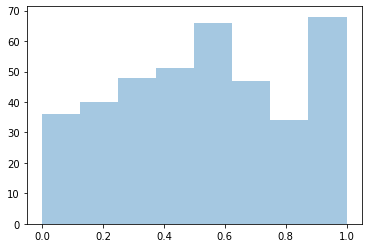

In [27]:
#sns.distplot(all_revisions, kde=False)
sns.distplot(all_precision_src, kde=False)

<AxesSubplot:>

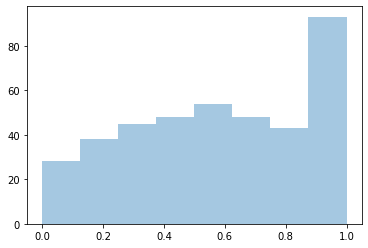

In [28]:
sns.distplot(all_precision_tgt, kde=False)

<AxesSubplot:>

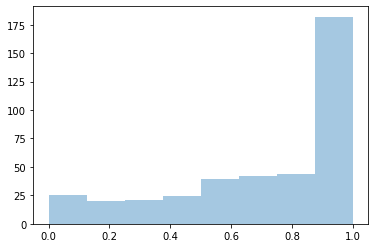

In [29]:
sns.distplot(all_recall_tgt, kde=False)

<AxesSubplot:>

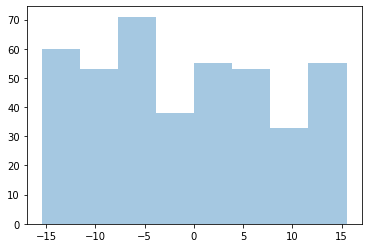

In [168]:
sns.distplot(final_score, kde=False)

In [169]:
for phrase in phrases:
    if len(phrase[2].split(' ')) == 1 or len(phrase[3].split(' ')) == 1 :
        print(f'{phrase[2]} |||{phrase[3]}')

IV |||IV ,
of |||d' entre
IV |||IV , roi
lands |||terres
1479 |||de 1479
of |||roi de
annexed |||annexe
. |||.
Kings |||roi
to |||à
them |||eux
last |||dernier
to |||à la
, |||,
them |||entre eux
Pyrrenean |||pyrénéennes
Foix |||Foix
of |||de
 |||en 1607
From |||partir de
of |||, roi de
of |||d'
France |||France
France |||France en
France |||France
made |||devenu
, |||en 1607 ,
the |||le
, |||,
of |||de
Navarre |||Navarre
and |||et
his |||ses
France |||la France
the |||le
1479 |||1479
France |||France en 1607
became |||devient
From |||partir
 |||, roi
Counts |||comte
of |||de
IV |||IV
, |||1607 ,
From |||À partir
, |||,
Henri |||Henri
From |||À partir de


In [170]:
en2fr

[(0, 1),
 (1, 3),
 (2, 4),
 (3, 5),
 (4, 6),
 (5, 7),
 (6, 8),
 (7, 9),
 (8, 10),
 (9, 11),
 (10, 12),
 (11, 13),
 (12, 14),
 (13, 15),
 (14, 16),
 (15, 18),
 (16, 19),
 (17, 20),
 (18, 21),
 (19, 22),
 (20, 25),
 (21, 26),
 (22, 29),
 (23, 30),
 (24, 31),
 (25, 33),
 (26, 32),
 (27, 34),
 (28, 36),
 (29, 37)]

In [171]:
verbose = False
en_aligned, fr_aligned, en_unaligned, fr_unaligned = [], [], [], []
for (en_a, fr_a) in en2fr:
    en_aligned.append(en_a)
    fr_aligned.append(fr_a)

en_unaligned_phrase, fr_unaligned_phrase = [], []
for i in range(len(en_text.split(' '))):
    if i not in en_aligned:
        en_unaligned_phrase.append(en_text.split(' ')[i])
        if verbose:
            print(en_text.split(' ')[i])
    else:
        if en_unaligned_phrase:
            en_unaligned.append(' '.join(en_unaligned_phrase))
        en_unaligned_phrase = []

for i in range(len(fr_text.split(' '))):
    if i not in fr_aligned:
        fr_unaligned_phrase.append(fr_text.split(' ')[i])
        if verbose:
            print(fr_text.split(' ')[i])
    else:
        if fr_unaligned_phrase:
            fr_unaligned.append(' '.join(fr_unaligned_phrase))
        fr_unaligned_phrase = []

print(en_unaligned)
print(fr_unaligned)

[]
['À', 'de', 'entre', ', roi', 'en 1607', 'la']


In [22]:
en_text

'The books are displayed in sixteen rooms over two floors of the specially built museum .'

In [25]:
en_aligned

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [41]:
display_HTML(en_text, en_div)
display_HTML(fr_text, fr_div)

In [32]:
phrases

[[None, None, 'as', ''],
 [None, None, ', and did not begin painting', ''],
 [None, None, 'old', ''],
 [None, None, '', 'a'],
 [None, None, '', 'le métier'],
 [None, None, '', 'en'],
 [None, None, '', 'âgé alors']]

In [72]:
def Sort(sub_li):
  
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of 
    # sublist lambda has been used
    sub_li.sort(key = lambda x: x[1])
    return sub_li

a = Sort(phrasal_annotations
    )

In [73]:
for b in a:
    print(b[1])
    print(b[0][2])
    print('\n')
    print(b[0][3])
    
    print('\n')

[[-15.307552]]
is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of


est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est


[[-15.307092]]
god of war ) ; Patricius ( that is , father of


deus belli ) , Patricius ( qui est pater ciuium


[[-15.306742]]
is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the


est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est


[[-15.306587]]
father of the citizens ) ; Cothirtiacus ( because


pater ciuium ) ; Cothirthiacus (


[[-15.306587]]
, father of the citizens ) ; Cothirtiacus ( because


pater ciuium ) ; Cothirthiacus (


[[-15.306297]]
, " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of the citizens ) ; Cothirtiacus (


est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater ciuium ) ; Cothirthiacus ( quia


[[-15.306297]]
famous " ) ; Succetus ( that is , the god of war ) ; P

[[-15.256863]]
" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father


clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater


[[-15.256863]]
famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father


clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater


[[-15.256863]]
, " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father


clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater


[[-15.256802]]
four names for Patrick written


les quatre noms de Patrick qu'


[[-15.256004]]
Cothirtiacus ( because


Cothirthiacus ( quia


[[-15.256004]]
; Cothirtiacus ( because


; Cothirthiacus ( quia


[[-15.256004]]
) ; Cothirtiacus ( because


) ; Cothirthiacus ( quia


[[-15.255526]]
of the citizens ) ; Cothirtiacus (


ciuium ) ; Cothirthiacus ( quia


[[-15.255427]]
four names for Patrick written


les quatre noms de Patrick


[[-15.254309]]
god of war ) ; Pat

[[-15.218029]]
is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is ,


clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater


[[-15.218029]]
is , " famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is


clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est pater


[[-15.21713]]
Magonus ( that


Magonus ( qui est


[[-15.217049]]
, father of the citizens ) ; Cothirtiacus (


pater ciuium ) ; Cothirthiacus ( quia


[[-15.217049]]
father of the citizens ) ; Cothirtiacus (


pater ciuium ) ; Cothirthiacus ( quia


[[-15.21666]]
the god of war ) ; Patricius ( that is , father of the citizens )


deus belli ) , Patricius ( qui est pater ciuium )


[[-15.21666]]
the god of war ) ; Patricius ( that is , father of the citizens ) ;


deus belli ) , Patricius ( qui est pater ciuium ) ;


[[-15.21666]]
the god of war ) ; Patricius ( that is , father of the citizens


deus belli ) , Patricius ( qui est pater ciuium


[[-15

[[-15.173407]]
found


trouvés


[[-15.173407]]
found


trouvés ,


[[-15.173231]]
, the god of war ) ; Patricius ( that is , father of the citizens


deus belli ) , Patricius ( qui est


[[-15.173231]]
the god of war ) ; Patricius ( that is , father of the citizens


deus belli ) , Patricius ( qui est


[[-15.172939]]
of the citizens ) ; Cothirtiacus ( because


) ; Cothirthiacus ( quia


[[-15.172853]]
) ; Cothirtiacus (


) ; Cothirthiacus ( quia


[[-15.172853]]
; Cothirtiacus (


; Cothirthiacus ( quia


[[-15.172853]]
Cothirtiacus (


Cothirthiacus ( quia


[[-15.172321]]
of the citizens ) ; Cothirtiacus ( because


ciuium ) ; Cothirthiacus (


[[-15.171011]]
( that is , the god of war ) ; Patricius ( that is , father of the citizens


( qui est deus belli ) , Patricius ( qui est


[[-15.171011]]
that is , the god of war ) ; Patricius ( that is , father of the citizens


qui est deus belli ) , Patricius ( qui est


[[-15.169538]]
; Patricius ( that is , father of the citizens ) ;

[[-15.12266]]
( that is


( qui est


[[-15.12266]]
( that is ,


( qui est


[[-15.12266]]
( that is ,


( qui est


[[-15.12266]]
that is


qui est


[[-15.122377]]
holy Magonus ( that is , " famous " ) ; Succetus ( that is , the god of


Sanctus Magonus ( qui est clarus ) ; Succetus ( qui est deus


[[-15.122004]]
of


de


[[-15.121796]]
Magonus ( that is , "


Sanctus Magonus ( qui


[[-15.121796]]
Magonus ( that is ,


Sanctus Magonus ( qui


[[-15.121796]]
Magonus ( that is


Sanctus Magonus ( qui


[[-15.12157]]
four names


les quatre noms


[[-15.119608]]
Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war )


Sanctus Magonus ( qui est clarus ) ; Succetus ( qui est deus belli )


[[-15.119608]]
Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war


Sanctus Magonus ( qui est clarus ) ; Succetus ( qui est deus belli


[[-15.119608]]
Magonus ( that is , " famous " ) ; Succetus ( that is , the god of war ) ;


Sanctus Magonus ( qui est clarus 

[[-15.077198]]
is , " famous " ) ; Succetus ( that is , the god of war


clarus ) ; Succetus ( qui est deus belli


[[-15.077198]]
is , " famous " ) ; Succetus ( that is , the god of war ) ;


clarus ) ; Succetus ( qui est deus belli ) ,


[[-15.076413]]
of the citizens ) ; Cothirtiacus (


ciuium ) ; Cothirthiacus (


[[-15.076413]]
of the citizens ) ; Cothirtiacus


ciuium ) ; Cothirthiacus


[[-15.075207]]
that is , " famous " ) ; Succetus ( that is , the god of


qui est clarus ) ; Succetus ( qui est deus


[[-15.075207]]
( that is , " famous " ) ; Succetus ( that is , the god of


( qui est clarus ) ; Succetus ( qui est deus


[[-15.075092]]
, " famous " ) ; Succetus ( that is , the god of war )


est clarus ) ; Succetus ( qui est deus belli ) ,


[[-15.075092]]
, " famous " ) ; Succetus ( that is , the god of war )


est clarus ) ; Succetus ( qui est deus belli )


[[-15.075092]]
famous " ) ; Succetus ( that is , the god of war


est clarus ) ; Succetus ( qui est deus belli


[[-


est clarus )


[[-15.023331]]
is , the god of war ) ; Patricius (


est deus belli ) , Patricius (


[[-15.023331]]
is , the god of war ) ; Patricius


est deus belli ) , Patricius


[[-15.023279]]
that is


qui est pater ciuium


[[-15.023279]]
( that is ,


( qui est pater ciuium


[[-15.023279]]
( that is


( qui est pater ciuium


[[-15.023279]]
that is ,


qui est pater ciuium


[[-15.022757]]
Patricius ( that is , father of


, Patricius ( qui est pater


[[-15.022757]]
) ; Patricius ( that is , father of


) , Patricius ( qui est pater


[[-15.022757]]
Patricius ( that is , father of


Patricius ( qui est pater


[[-15.022757]]
; Patricius ( that is , father of


, Patricius ( qui est pater


[[-15.022757]]
; Patricius ( that is , father of


Patricius ( qui est pater


[[-15.018856]]
god of war ) ; Patricius ( that


deus belli ) , Patricius ( qui


[[-15.018168]]
of war ) ; Patricius ( that is


belli ) , Patricius ( qui est pater


[[-15.018168]]
of war ) ; Patricius ( that 

[[-14.963414]]
Magonus ( that is , " famous " ) ; Succetus ( that is , the


Magonus ( qui est clarus ) ; Succetus ( qui est


[[-14.963289]]
of war ) ; Patricius ( that


belli ) , Patricius ( qui


[[-14.96096]]
writes ,


rapporte les


[[-14.96096]]
writes


rapporte les


[[-14.956869]]
is , " famous " ) ; Succetus ( that is , the god


clarus ) ; Succetus ( qui est deus


[[-14.955657]]
is , father


est


[[-14.953661]]
famous " ) ; Succetus ( that


clarus ) ; Succetus ( qui


[[-14.953661]]
, " famous " ) ; Succetus ( that


clarus ) ; Succetus ( qui


[[-14.953661]]
" famous " ) ; Succetus ( that


clarus ) ; Succetus ( qui


[[-14.953079]]
; Patricius ( that is ,


, Patricius ( qui est pater


[[-14.953079]]
Patricius ( that is


Patricius ( qui est pater


[[-14.953079]]
; Patricius ( that is


, Patricius ( qui est pater


[[-14.953079]]
; Patricius ( that is


Patricius ( qui est pater


[[-14.953079]]
) ; Patricius ( that is


) , Patricius ( qui est pater


[[-14.95307

is


est


[[-14.875271]]
" ) ; Succetus


; Succetus


[[-14.875271]]
" ) ; Succetus


) ; Succetus


[[-14.875271]]
) ; Succetus (


) ; Succetus (


[[-14.875271]]
Succetus


Succetus


[[-14.875271]]
; Succetus (


) ; Succetus (


[[-14.875271]]
) ; Succetus (


; Succetus (


[[-14.875271]]
Succetus (


Succetus (


[[-14.875271]]
" ) ; Succetus (


; Succetus (


[[-14.875271]]
; Succetus


; Succetus


[[-14.875271]]
; Succetus


) ; Succetus


[[-14.875271]]
) ; Succetus


) ; Succetus


[[-14.875271]]
) ; Succetus


; Succetus


[[-14.875271]]
" ) ; Succetus (


) ; Succetus (


[[-14.875271]]
; Succetus (


; Succetus (


[[-14.868788]]
because he


qu' il a


[[-14.866238]]
of Conchobar :


:


[[-14.863716]]
I found


trouvés ,


[[-14.863716]]
I found


trouvés


[[-14.859112]]
bishop of


évêque


[[-14.858929]]
written in the book of


dans le Livre de


[[-14.857028]]
Patricius ( that is , father of the


, Patricius ( qui est pater


[[-14.857028]]
) ; Patricius ( tha

In [66]:
for a in phrases:
    if len(a[2].split(' ')) < 8:
        print(a[2])
        print(a[3])
        print('\n')

) ; Cothirtiacus (
) ; Cothirthiacus ( quia


he
qu' il a


; Cothirtiacus (
; Cothirthiacus (


; Patricius ( that is ,
Patricius ( qui est


Patricius ( that is , father of
, Patricius ( qui est pater


that is , father of
qui est pater ciuium


in the book of
dans le Livre de


) ; Succetus ( that is
) ; Succetus ( qui est


" ) ;
) ;


the book of
le Livre de


holy Magonus ( that is , "
Magonus ( qui est


the
le


) ; Cothirtiacus
pater ciuium ) ; Cothirthiacus


) ;
ciuium ) ;


written in the book
dans le Livre


Magonus (
Sanctus Magonus (


( that is , father
( qui est


" ) ; Succetus
; Succetus


" famous " ) ; Succetus (
clarus ) ; Succetus (


Patricius ( that is , father of
, Patricius ( qui est pater ciuium


four names for Patrick written
quatre noms de Patrick


that is , father of the citizens
qui est pater ciuium


) ; Cothirtiacus ( because
ciuium ) ; Cothirthiacus ( quia


( because
(


is ,
est pater ciuium


father of the citizens ) ; Cothirtiacus
) ; Cothirthia



holy Magonus ( that
Magonus ( qui


, " famous " ) ;
clarus ) ;


of the tribe of
l'


famous "
est clarus


; Succetus ( that is
) ; Succetus ( qui est


; Patricius ( that is
Patricius ( qui est pater ciuium


the citizens )
ciuium )


citizens ) ; Cothirtiacus (
ciuium ) ; Cothirthiacus ( quia


) ; Patricius (
) , Patricius (


of
de


that is , "
qui


Patricius ( that is , father
, Patricius ( qui est pater ciuium


) ; Patricius ( that is ,
) , Patricius ( qui est


famous
est clarus )


; Patricius (
, Patricius (


war ) ; Patricius ( that
belli ) , Patricius ( qui


( that is ,
( qui est pater


the citizens ) ; Cothirtiacus ( because
pater ciuium ) ; Cothirthiacus ( quia


of war )
belli )


that is , father of the
qui est pater ciuium


holy Magonus ( that is ,
Sanctus Magonus ( qui


that is ,
qui est


of the citizens ) ; Cothirtiacus (
ciuium ) ; Cothirthiacus (


of the tribe
l'


; Succetus ( that is , the
) ; Succetus ( qui est


( that
( qui


famous "
clarus


nam

In [71]:
phrasal_annotations

[[((55, 59), (45, 50), ') ; Cothirtiacus (', ') ; Cothirthiacus ( quia'),
  array([[-15.172853]], dtype=float32)],
 [((42, 55),
   (36, 45),
   'of war ) ; Patricius ( that is , father of the citizens',
   'belli ) , Patricius ( qui est pater ciuium'),
  array([[-15.213956]], dtype=float32)],
 [((56, 59), (46, 49), '; Cothirtiacus (', '; Cothirthiacus ('),
  array([[-15.156414]], dtype=float32)],
 [((30, 53),
   (27, 43),
   '" famous " ) ; Succetus ( that is , the god of war ) ; Patricius ( that is , father of',
   'est clarus ) ; Succetus ( qui est deus belli ) , Patricius ( qui est'),
  array([[-15.270839]], dtype=float32)],
 [((26, 44),
   (25, 37),
   '( that is , " famous " ) ; Succetus ( that is , the god of war',
   '( qui est clarus ) ; Succetus ( qui est deus belli'),
  array([[-15.10041]], dtype=float32)],
 [((45, 51), (39, 43), '; Patricius ( that is ,', 'Patricius ( qui est'),
  array([[-14.976034]], dtype=float32)],
 [((46, 53),
   (38, 44),
   'Patricius ( that is , fath